In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from pandas_profiling import ProfileReport
from geopy.distance import geodesic
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline

print("Pandas Version: " + pd.__version__)
print("Numpy Version: " + np.__version__)
print("Seaborn Version: " + sns.__version__)

Pandas Version: 1.2.0
Numpy Version: 1.18.5
Seaborn Version: 0.11.1


In [2]:
df = pd.read_csv("../data/call_a_bike/OPENDATA_BOOKING_CALL_A_BIKE.csv", sep=";")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16228298 entries, 0 to 16228297
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   BOOKING_HAL_ID             int64  
 1   CATEGORY_HAL_ID            int64  
 2   VEHICLE_HAL_ID             int64  
 3   CUSTOMER_HAL_ID            object 
 4   DATE_BOOKING               object 
 5   DATE_FROM                  object 
 6   DATE_UNTIL                 object 
 7   COMPUTE_EXTRA_BOOKING_FEE  object 
 8   TRAVERSE_USE               object 
 9   DISTANCE                   float64
 10  START_RENTAL_ZONE          object 
 11  START_RENTAL_ZONE_HAL_ID   float64
 12  END_RENTAL_ZONE            object 
 13  END_RENTAL_ZONE_HAL_ID     float64
 14  RENTAL_ZONE_HAL_SRC        object 
 15  CITY_RENTAL_ZONE           object 
 16  TECHNICAL_INCOME_CHANNEL   object 
dtypes: float64(3), int64(3), object(11)
memory usage: 2.1+ GB


In [4]:
df.head(3)

,BOOKING_HAL_ID,CATEGORY_HAL_ID,VEHICLE_HAL_ID,CUSTOMER_HAL_ID,DATE_BOOKING,DATE_FROM,DATE_UNTIL,COMPUTE_EXTRA_BOOKING_FEE,TRAVERSE_USE,DISTANCE,START_RENTAL_ZONE,START_RENTAL_ZONE_HAL_ID,END_RENTAL_ZONE,END_RENTAL_ZONE_HAL_ID,RENTAL_ZONE_HAL_SRC,CITY_RENTAL_ZONE,TECHNICAL_INCOME_CHANNEL
0,21366843,51000,143517,A821059B555C7764A2FF801180874A2FCB326222,2014-01-01 00:34:54,2014-01-01 00:34:54,2014-01-01 00:50:14,Nein,Nein,0.0,U-Bahn Baumwall,214170.0,Mönckebergstraße / Rosenstraße,131880.0,Standort,Hamburg,iPhone SRH
1,21367069,51000,119830,1EBC930DB407ACEAE2FDE23A6CA40492EA3DFBB2,2014-01-01 01:39:55,2014-01-01 01:39:55,2014-01-01 01:57:27,Nein,Nein,0.0,Bahnhof Altona Ost/Max-Brauer-Allee,131646.0,Schulterblatt/Eifflerstraße,131648.0,Standort,Hamburg,Android SRH
2,21367072,51000,143501,7AD2C1B70137479062A6DD73815835986677BB2D,2014-01-01 01:40:20,2014-01-01 01:40:20,2014-01-01 01:53:09,Nein,Nein,0.0,Weidestraße/Biedermannplatz,211922.0,Jarrestraße / Rambatzweg,138376.0,Standort,Hamburg,Techniker HH_119 (-2334-)


In [5]:
df.tail(3)

,BOOKING_HAL_ID,CATEGORY_HAL_ID,VEHICLE_HAL_ID,CUSTOMER_HAL_ID,DATE_BOOKING,DATE_FROM,DATE_UNTIL,COMPUTE_EXTRA_BOOKING_FEE,TRAVERSE_USE,DISTANCE,START_RENTAL_ZONE,START_RENTAL_ZONE_HAL_ID,END_RENTAL_ZONE,END_RENTAL_ZONE_HAL_ID,RENTAL_ZONE_HAL_SRC,CITY_RENTAL_ZONE,TECHNICAL_INCOME_CHANNEL
16228295,46385839,51000,120488,CC6405146B51242A9169AB55E88A5C472EA1B2AA,2017-05-16 07:40:17,2017-05-16 07:40:17,2017-05-16 07:50:07,Ja,Nein,0.0,Weidestraße/Biedermannplatz,211922.0,Mundsburg / Schürbeker Straße,140799.0,Standort,Hamburg,Techniker HH_119 (-2334-)
16228296,46386510,50000,116623,AE105561D195C422985C2B3BB1A790C187DA3A70,2017-05-16 08:02:12,2017-05-16 08:02:12,2017-05-23 08:02:12,Ja,Nein,NaN,NaN,NaN,NaN,NaN,NaN,Darmstadt,iPhone CAB
16228297,46386791,50000,110529,DBB967CDDB3C6D5F0C7CC7A2FF2E8CC89B5ECE6E,2017-05-16 08:11:13,2017-05-16 08:11:13,2017-05-23 08:11:13,Ja,Nein,NaN,NaN,NaN,NaN,NaN,NaN,Darmstadt,iPhone CAB


In [6]:
# Select trips made in Hamburg

trips = df[df.CITY_RENTAL_ZONE == "Hamburg"]

In [7]:
last_count = trips.shape[0]

def print_count_data():
    current_count = trips.shape[0]
    diff = current_count - last_count
    print('% s entries, diff: % s'%(current_count, diff)) 
    return current_count

In [8]:
last_count = print_count_data()

8942261 entries, diff: 0


In [9]:
# Select and rename usable columns

trips = trips[[
    "VEHICLE_HAL_ID",
    "CUSTOMER_HAL_ID",
    "DATE_FROM",
    "DATE_UNTIL",
    "START_RENTAL_ZONE",
    "START_RENTAL_ZONE_HAL_ID",
    "END_RENTAL_ZONE",
    "END_RENTAL_ZONE_HAL_ID",
    "TECHNICAL_INCOME_CHANNEL",
]].copy()
trips.columns = [
    "bike_id",
    "user_id",
    "date_from",
    "date_until",
    "start_station_name", 
    "start_station_id",
    "end_station_name",
    "end_station_id",
    "booked_via"
]

In [10]:
trips.isna().sum()

bike_id                    0
user_id                    0
date_from                  0
date_until                 0
start_station_name       429
start_station_id         246
end_station_name         255
end_station_id           250
booked_via            120066
dtype: int64

In [11]:
# Fill unknown 'booked_via' with 'Unknown' because there are a lot (120,066)
# Drop other NaN rows since the amount is negligible

trips = trips.fillna({'booked_via': 'Unknown'})
trips = trips.dropna()

In [12]:
last_count = print_count_data()

8941801 entries, diff: -460


In [13]:
# Convert float IDs to integer values

trips["start_station_id"] = trips["start_station_id"].astype(int)
trips["end_station_id"] = trips["end_station_id"].astype(int)

In [14]:
# Examining 'booked_via' that start with 'Techniker'

techniker = trips[trips["booked_via"].str.contains("Techniker")]
non_techniker = pd.concat([trips, techniker]).drop_duplicates(keep=False)

tmp = non_techniker.loc[non_techniker.user_id.isin(techniker.user_id.unique())]
print('Number of trips with a user ID that booked via Techniker before: %s' % len(tmp.index))
tmp = non_techniker.loc[~non_techniker.user_id.isin(techniker.user_id.unique())]
print('Number of trips with a user ID that did not book via Techniker before: %s' % len(tmp.index))

# Assuming 'Techniker' means maintenance personnel is probably faulty.
# Around 50% of the user IDs are contained in the non_techniker trip data set.

Number of trips with a user ID that booked via Techniker before: 4104569
Number of trips with a user ID that did not book via Techniker before: 4108149


In [15]:
non_techniker.sample(5)

,bike_id,user_id,date_from,date_until,start_station_name,start_station_id,end_station_name,end_station_id,booked_via
2543427,120561,E2CB9734D932B3B8DFC32A4624FAD809AD6F822B,2014-08-04 20:51:26,2014-08-04 21:02:29,Neuer Pferdemarkt / Beim Grünen Jäger,131890,Bernhard-Nocht-Straße/Zirkusweg,196417,Unknown
11712550,119853,D9E98997473DE8056B772DA1C5EBF9BF002C647A,2016-07-09 22:12:40,2016-07-09 22:26:24,Eppendorfer Weg/Hoheluftchaussee,198086,Schulterblatt/Eifflerstraße,131648,iPhone SRH
4212173,119801,B69EABB8A6FBFBF86FADF456F55CABF8B9BE30F1,2014-12-13 01:36:45,2014-12-13 01:53:47,Neuer Pferdemarkt / Beim Grünen Jäger,131890,Bahnhof Altona West / Busbahnhof,131889,Terminal HH_49 (-2131-)
14729420,110585,4C04E5C107CBB067E6851EFC05C5284979760598,2017-01-16 20:37:51,2017-01-16 20:53:10,Jungfernstieg / Neuer Jungfernstieg,138380,Eppendorfer Weg/Hoheluftchaussee,198086,iPhone CAB
4255588,120462,F3645570017F46A6ADD8A706ACC145E538609CB0,2014-12-20 00:30:31,2014-12-20 00:34:05,Emilienstraße/Fruchtallee,213825,Heußweg/Wiesenstraße,201326,iPhone SRH


In [16]:
# Create a stations data set from all unique station IDs

station_ids = sorted(
    set(trips.start_station_id.tolist() + trips.end_station_id.tolist())
)
station_ids = pd.DataFrame(station_ids, columns=['station_id'])
station_ids

,station_id
0,131543
1,131546
2,131547
3,131639
4,131640
...,...
211,256467
212,264330
213,264820
214,264821


In [17]:
# Load DB data set about stations

db_stations = pd.read_csv("../data/call_a_bike/OPENDATA_RENTAL_ZONE_CALL_A_BIKE.csv", sep=";", decimal=",")
db_stations = db_stations[db_stations.CITY == "Hamburg"]
db_stations.sample(5)

,RENTAL_ZONE_HAL_ID,RENTAL_ZONE_HAL_SRC,NAME,CODE,TYPE,CITY,COUNTRY,LATITUDE,LONGITUDE,POI_AIRPORT_X,POI_LONG_DISTANCE_TRAINS_X,POI_SUBURBAN_TRAINS_X,POI_UNDERGROUND_X,ACTIVE_X,COMPANY,COMPANY_GROUP
469,204030,Standort,Wandsbeker Chaussee/Ritterstraße,2411.0,normal,Hamburg,Deutschland,10.044484,53.567126,Nein,Nein,Nein,Nein,Ja,StadtRAD Hamburg,Call a Bike
1048,264330,Standort,Bleickenallee/Kinderkrankenhaus Altona,2128.0,normal,Hamburg,Deutschland,9.912913,53.551288,Nein,Nein,Nein,Nein,Ja,StadtRAD Hamburg,Call a Bike
601,218636,Standort,Schopenstehl/Alter Fischmarkt,2635.0,normal,Hamburg,Deutschland,9.997126,53.548703,Nein,Nein,Nein,Nein,Ja,StadtRAD Hamburg,Call a Bike
954,252493,Standort,Elbchaussee/Teufelsbrück,2050.0,normal,Hamburg,Deutschland,9.862013,53.547425,Nein,Nein,Nein,Nein,Ja,StadtRAD Hamburg,Call a Bike
465,201329,Standort,Osakaallee/Übersee Quartier,2674.0,normal,Hamburg,Deutschland,9.999731,53.541583,Nein,Nein,Nein,Nein,Ja,StadtRAD Hamburg,Call a Bike


In [18]:
# Select coordinates for stations from DB data

coordinates = db_stations[["RENTAL_ZONE_HAL_ID", "NAME", "LATITUDE", "LONGITUDE"]].copy()
# coordinate descriptions are incorrectly labelled in the original data set
coordinates.columns = ["station_id", "name", "longitude", "latitude"]
coordinates.dropna(inplace=True)
coordinates

,station_id,name,longitude,latitude
350,131543,Landungsbrücke/Hafentor,9.972300,53.545700
351,131546,Fischmarkt/Breite Straße,9.950880,53.546200
352,131547,Paulinenplatz/Wohlwillstraße,9.962460,53.554200
353,131639,Burgstraße/Hammer Landstraße,10.041298,53.555693
354,131640,Innocentiapark/Oberstraße,9.982110,53.577248
...,...,...,...,...
1023,256467,Röntgenstraße/Philips,10.012209,53.623481
1048,264330,Bleickenallee/Kinderkrankenhaus Altona,9.912913,53.551288
1050,264820,Osterstraße/Heußweg,9.952071,53.575983
1051,264821,Bahrenfelder Chaussee/Von-Sauer-Straße,9.910870,53.565973


We can already see that the DB data set of stations does not seem to be complete. There are more unique IDs in the bike trip data set as in the stations data set (308 rows vs. 206 rows).

In [19]:
stations = pd.merge(station_ids, coordinates, how="left", on="station_id")
stations

,station_id,name,longitude,latitude
0,131543,Landungsbrücke/Hafentor,9.972300,53.545700
1,131546,Fischmarkt/Breite Straße,9.950880,53.546200
2,131547,Paulinenplatz/Wohlwillstraße,9.962460,53.554200
3,131639,Burgstraße/Hammer Landstraße,10.041298,53.555693
4,131640,Innocentiapark/Oberstraße,9.982110,53.577248
...,...,...,...,...
211,256467,Röntgenstraße/Philips,10.012209,53.623481
212,264330,Bleickenallee/Kinderkrankenhaus Altona,9.912913,53.551288
213,264820,Osterstraße/Heußweg,9.952071,53.575983
214,264821,Bahrenfelder Chaussee/Von-Sauer-Straße,9.910870,53.565973


In [20]:
missing_info_ids = stations[stations.name.isnull()].station_id.unique()
missing_info_ids

array([138370, 194453, 194553, 194563, 225361, 238540, 238543, 241576,
       242731, 246950])

In [21]:
a = df[df.START_RENTAL_ZONE_HAL_ID.isin(missing_info_ids)].START_RENTAL_ZONE.unique()
b = df[df.END_RENTAL_ZONE_HAL_ID.isin(missing_info_ids)].END_RENTAL_ZONE.unique()

list(set(a)|set(b))

['Maretstraße/Baererstraße',
 'Systemtechnik/Test Terminal',
 'F PS 1763 / BSC Hamburg Mobil',
 'Funkbox-BSC-HH',
 'F PS 2423 / BSC Hamburg Mobil',
 'Rotec Schlösser BSC',
 'Grindelberg / Bezirksamt Eimsbüttel',
 'BSCTerminal FFM 2.OG R 2.21',
 'BSC Testterminal Halle',
 'F R  5156 / BSC Hamburg Mobil']

To match missing stations with coordinates, the information available at https://suche.transparenz.hamburg.de/dataset/stadtrad-stationen-hamburg20 was considered. Only two stations are included: *Grindelberg / Bezirksamt Eimsbüttel* (ID 138370) and *Maretstraße/Baererstraße* (ID 242731). Coordinates for both stations can easily be added to the data set by hand.

**Coordinates**
* Grindelberg / Bezirksamt Eimsbüttel: [ 9.97782399971897, 53.57540799556665 ]
* Maretstraße / Baererstraße: [ 9.982274994484669, 53.453703999218654 ]

In [22]:
print(df[df.START_RENTAL_ZONE == "Grindelberg / Bezirksamt Eimsbüttel"].START_RENTAL_ZONE_HAL_ID.unique())
print(df[df.END_RENTAL_ZONE == "Grindelberg / Bezirksamt Eimsbüttel"].END_RENTAL_ZONE_HAL_ID.unique())

print(df[df.START_RENTAL_ZONE == "Maretstraße/Baererstraße"].START_RENTAL_ZONE_HAL_ID.unique())
print(df[df.END_RENTAL_ZONE == "Maretstraße/Baererstraße"].END_RENTAL_ZONE_HAL_ID.unique())

[138370.]
[138370.]
[242731.]
[242731.]


In [23]:
stations.loc[stations.station_id == 138370, "name"] = "Grindelberg / Bezirksamt Eimsbüttel"
stations.loc[stations.station_id == 138370, "longitude"] = 9.977824
stations.loc[stations.station_id == 138370, "latitude"] = 53.575408

stations.loc[stations.station_id == 242731, "name"] = "Maretstraße/Baererstraße"
stations.loc[stations.station_id == 242731, "longitude"] = 9.982275
stations.loc[stations.station_id == 242731, "latitude"] = 53.453704

In [24]:
missing_locations = [
 'F PS 1763 / BSC Hamburg Mobil',
 'BSCTerminal FFM 2.OG R 2.21',
 'Rotec Schlösser BSC',
 'BSC Testterminal Halle',
 'Funkbox-BSC-HH',
 'Systemtechnik/Test Terminal',
 'F PS 2423 / BSC Hamburg Mobil',
 'F R  5156 / BSC Hamburg Mobil'
]

In [25]:
# Remove all trips where either the start or end station is of unknown location

nan_trips = trips[
    (trips.start_station_name.isin(missing_locations)) |
    (trips.end_station_name.isin(missing_locations))
]
trips.drop(nan_trips.index, inplace=True) 

In [26]:
last_count = print_count_data()

8923066 entries, diff: -18735


In [27]:
# Calculate duration in minutes (rounded up) for each trip

def calculate_duration_in_min(date_from, date_until):
    duration_in_seconds = pd.to_datetime(date_until) - pd.to_datetime(date_from)
    return np.ceil(duration_in_seconds / pd.Timedelta(minutes=1))

trips.loc[:, "duration_in_min"] = calculate_duration_in_min(trips["date_from"], trips["date_until"])
trips["duration_in_min"] = trips["duration_in_min"].astype(int)

In [28]:
# Remove trips shorter than 3 minutes starting and ending at the same station
# These are probably trips that were not intentional or canceled due to issues with the bike

mask = (trips.duration_in_min < 3) & (trips.start_station_id == trips.end_station_id)
trips = trips.drop(trips[mask].index)

In [29]:
last_count = print_count_data()

8476307 entries, diff: -446759


Duration for 75 of the trips: 22 minutes


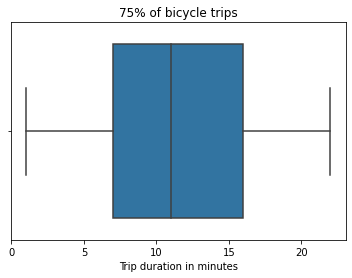

Duration for 85 of the trips: 28 minutes


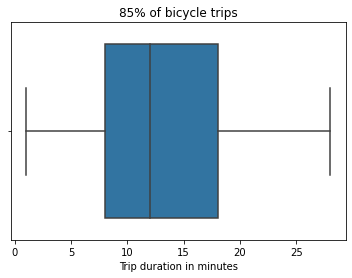

Duration for 90 of the trips: 33 minutes


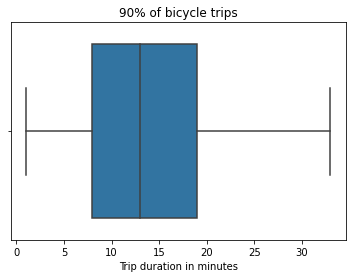

Duration for 93 of the trips: 39 minutes


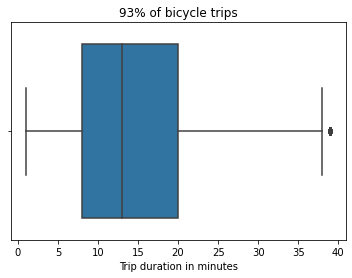

Duration for 95 of the trips: 49 minutes


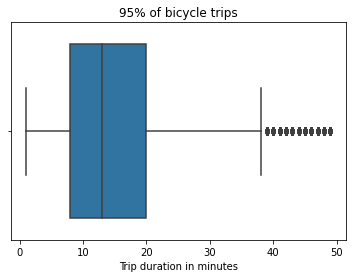

Duration for 99 of the trips: 208 minutes


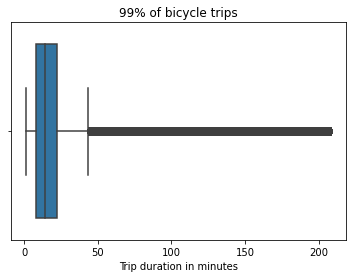

In [30]:
quantiles = [0.75, 0.85, 0.90, 0.93, 0.95, 0.99]

for quantile in quantiles:
    threshold = trips.duration_in_min.quantile(quantile)
    print('Duration for {0} of the trips: {1} minutes'.format(int(quantile*100), int(threshold)))
    sns.boxplot(x='duration_in_min', data=trips[trips.duration_in_min <= threshold])
    plt.title('{}% of bicycle trips'.format(int(quantile*100), threshold))
    plt.xlabel('Trip duration in minutes')
    plt.savefig('figures/duration_in_min_quantile_{}.png'.format(int(quantile*100)))
    plt.show()

In [31]:
# Remove outliers based on trip duration

threshold = trips.duration_in_min.quantile(0.9)
print('Trip duration threshold: %s minutes' % threshold)

trips.drop(trips[trips.duration_in_min > threshold].index, inplace=True) 

Trip duration threshold: 33.0 minutes


In [32]:
last_count = print_count_data()

7669950 entries, diff: -806357


In [33]:
# Compute distace for each trip in kilometers

trips_copy = trips[["start_station_id", "end_station_id"]].copy()

start_stations = stations[["station_id", "latitude", "longitude"]]
start_stations.columns = ["station_id", "start_latitude", "start_longitude"]
end_stations = stations[["station_id", "latitude", "longitude"]]
end_stations.columns = ["station_id", "end_latitude", "end_longitude"]

trips_copy = pd.merge(trips_copy, start_stations, how="left", left_on="start_station_id", right_on="station_id")
trips_copy = pd.merge(trips_copy, end_stations, how="left", left_on="end_station_id", right_on="station_id")
trips_copy

,start_station_id,end_station_id,station_id_x,start_latitude,start_longitude,station_id_y,end_latitude,end_longitude
0,214170,131880,214170,53.544279,9.980896,131880,53.550722,9.997140
1,131646,131648,131646,53.552121,9.936005,131648,53.562709,9.960990
2,211922,138376,211922,53.580004,10.033846,138376,53.584000,10.021100
3,140799,211923,140799,53.569600,10.027100,211923,53.575652,10.029570
4,208295,213833,208295,53.576238,10.058237,213833,53.573588,10.049568
...,...,...,...,...,...,...,...,...
7669945,131648,211711,131648,53.562709,9.960990,211711,53.550966,9.922260
7669946,131650,244943,131650,53.547100,9.942410,244943,53.552339,9.930344
7669947,201326,243618,201326,53.577796,9.953073,243618,53.575573,9.944487
7669948,131646,131890,131646,53.552121,9.936005,131890,53.558869,9.963824


In [43]:
x = (trips_copy.loc[0].start_latitude, trips_copy.loc[0].start_longitude)
y = (trips_copy.loc[0].end_latitude, trips_copy.loc[0].end_longitude)
geodesic(x, y).km

1.293661161455801

In [44]:
trips_copy["distance_in_km"] = trips_copy.apply(
    lambda x: geodesic(
        (x.start_latitude, x.start_longitude),
        (x.end_latitude, x.end_longitude)
    ),
    axis=1
)
trips_copy

KeyboardInterrupt: 

In [76]:
station_ids = stations.station_id.to_numpy()
distances = stations[["station_id"]].reset_index()

# calculate matrix for station_id x station_id and fill with distance between each

for index_x, row_x in distances.iterrows():
    for index_y, row_y in distances.iterrows():
        station_x = stations.loc[index_x]
        station_y = stations.loc[index_y]
        distance_xy = geodesic(
            (station_x.latitude, station_x.longitude),
            (station_y.latitude, station_y.longitude)
        )
        distances[row_y] = distance_xy

distances

ValueError: Point coordinates must be finite. (nan, nan, 0.0) has been passed as coordinates.

In [ ]:
trips

In [143]:
trips["distance_in_km"] = trips_copy["distance_in_km"]

ValueError: can only convert an array of size 1 to a Python scalar

In [35]:
trips.sample(4)

,bike_id,user_id,date_from,date_until,start_station_name,start_station_id,end_station_name,end_station_id,booked_via,duration_in_min
2103035,120496,1BABCF5DC03E0675BCD1D5EEEF0C6D71486DA721,2014-07-11 15:00:41,2014-07-11 15:49:54,Heußweg/Wiesenstraße,201326,Heußweg/Wiesenstraße,201326,Terminal HH_11 (-2225-),50
13076230,120532,444C2E223A96506BEDA7D9E9F37676457D668927,2016-09-09 11:11:24,2016-09-09 12:00:34,Jungfernstieg / Neuer Jungfernstieg,138380,Neumühlen/Övelgönne,213856,Terminal HH_14 (-2523-),50
5285735,119722,764C9CDFD890E2278E917C159D2EEB5D740F6C98,2015-05-03 14:52:25,2015-05-03 16:29:54,Jungfernstieg / Ballindamm,131879,Wandsbeker Marktstraße/Wandsbeker Marktplatz,204032,Terminal HH_25 (-2533-),98
8360521,120163,EB54D3139EBA335AB5A8AB23B3FE5FD389A1D8F3,2015-11-06 03:13:22,2015-11-06 03:54:49,Lange Reihe / Lohmühlenpark,138385,Berliner Tor / Berlinertordamm,131652,Terminal HH_32 (-2544-),42


In [165]:
#ProfileReport(trips_clean).to_notebook_iframe()

In [234]:
#stations.to_csv('../data/clean/stations.csv', index=False)

,station_id,station_name
0,131543,Landungsbrücke/Hafentor
1,131546,Fischmarkt/Breite Straße
2,131547,Paulinenplatz/Wohlwillstraße
3,131639,Burgstraße/Hammer Landstraße
4,131640,Innocentiapark/Oberstraße
...,...,...
303,270018,NaN
304,271541,NaN
305,271751,NaN
306,272248,NaN


In [236]:
stations[stations.station_name.isna()]

,station_id,station_name
67,144871,NaN
68,144890,NaN
69,145340,NaN
73,164314,NaN
138,233524,NaN
...,...,...
303,270018,NaN
304,271541,NaN
305,271751,NaN
306,272248,NaN


In [237]:
trips_clean[trips_clean.start_station_id == 270018.0]

,bike_id,user_id,date_from,date_until,start_station_id,end_station_id,booked_via,duration_in_min
15389019,116012,EA0157EBD1FAB6B45E78527F874DE0BE8E3EC53F,2017-03-23 22:08:27,2017-03-23 22:17:36,270018,264820,iPhone SRH,10


In [238]:
station_id = 158204

id_rows_start = df[df.START_RENTAL_ZONE_HAL_ID == float(station_id)]
names_start = id_rows_start.START_RENTAL_ZONE.unique().tolist()
id_rows_end = df[df.END_RENTAL_ZONE_HAL_ID == float(station_id)]
names_end = id_rows_end.END_RENTAL_ZONE.unique().tolist()

set(names_start + names_end).pop()

'Alter Wall/Adolphsbrücke'

<AxesSubplot:xlabel='duration_in_min'>

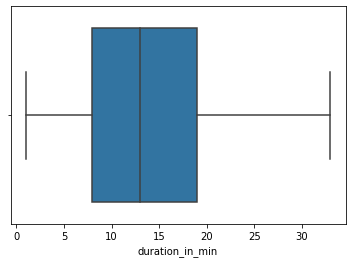

In [239]:
sns.boxplot(x=trips_clean['duration_in_min'])

In [240]:
trips_clean.sample(5)

,bike_id,user_id,date_from,date_until,start_station_id,end_station_id,booked_via,duration_in_min
15974395,120321,E0E23B36954EFA6B531A10A59EA4BEFFD6D1AE4F,2017-05-01 14:04:22,2017-05-01 14:24:32,204030,211920,Terminal HH_16 (-2411-),21
15790214,109863,2457DF18968E613AC22F7D3F14EC24598B764858,2017-04-19 01:06:46,2017-04-19 01:18:04,212607,245204,iPhone SRH,12
5169595,120064,00BA82F74B652633296511A5A9BB1F49BE1EBB70,2015-04-24 15:53:10,2015-04-24 16:19:15,140793,213825,Terminal HH_68 (-2373-),27
2915383,143574,6AAE1768F09D2C308CD62394745B3F8338A43E09,2014-08-29 13:18:03,2014-08-29 13:29:11,211706,196417,Android SRH,12
5852904,120008,6C80E2223ADD4A419513B95A2AED4513EECD4341,2015-06-06 21:17:22,2015-06-06 21:45:05,131543,193238,Android SRH,28


In [241]:
# Save clean data set as CSV

#trips_clean.to_csv('../data/clean/trips.csv', index=False)